In [25]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

from catboost import Pool, CatBoostClassifier 

import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()

In [2]:
df = pd.read_csv('/Users/anshilina/Downloads/Maternal Health Risk Data Set.csv')

In [3]:
df.shape

(1014, 7)

In [4]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1014.0,NaN,NaN,NaN,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,NaN,NaN,NaN,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,NaN,NaN,NaN,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,NaN,NaN,NaN,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,NaN,NaN,NaN,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,NaN,NaN,NaN,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0
RiskLevel,1014,3,low risk,406,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df['BodyTemp'] = (df['BodyTemp'] - 32) * 5/9

In [7]:
df['BodyTemp'].describe()

count    1014.000000
mean       37.036160
std         0.761880
min        36.666667
25%        36.666667
50%        36.666667
75%        36.666667
max        39.444444
Name: BodyTemp, dtype: float64

In [8]:
df['MeanBP'] = (df['SystolicBP'] + 2*df['DiastolicBP'])/3

In [9]:
df[['MeanBP', 'SystolicBP', 'DiastolicBP']].head()

,MeanBP,SystolicBP,DiastolicBP
0,96.666667,130,80
1,106.666667,140,90
2,76.666667,90,70
3,103.333333,140,85
4,80.000000,120,60


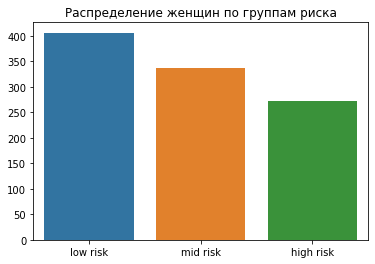

In [10]:
sns.barplot(data = df, x=df['RiskLevel'].value_counts().index, y=df['RiskLevel'].value_counts().values)
plt.title('Распределение женщин по группам риска');

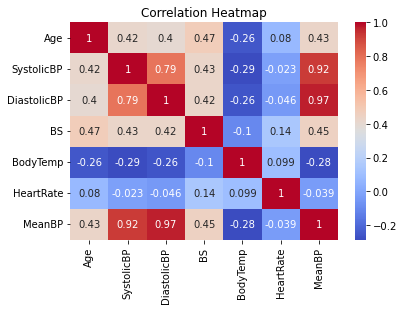

In [11]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Сильная корреляция MeanBP, SystolicBP, DiastolicBP. Не стоит использовать линейные модели.

In [12]:
features, target = df.drop('RiskLevel', axis=1), df['RiskLevel']

In [13]:
le = LabelEncoder()
target_enc = le.fit_transform(target)

In [14]:
le.inverse_transform([0, 1, 2])

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [15]:
features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25, stratify=target, random_state=42)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
 7   MeanBP       1014 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 63.5+ KB


### Catboost

In [17]:
train_dataset = Pool(data=features_train,
                     label=target_train)

eval_dataset = Pool(data=features_test,
                    label=target_test)

# Initialize CatBoostClassifier
cat_model = CatBoostClassifier(random_seed=42, loss_function='MultiClass', silent=True)

In [18]:
cat_grid = {'depth':[6, 9, 10, 11],
            'iterations': [100, 150, 200]} 

cat_gs = GridSearchCV(cat_model, cat_grid, cv=5)

In [19]:
cat_gs.fit(features_train, target_train)
print("Best hyperparameter:", cat_gs.best_params_)
print("Best cross-val score:", cat_gs.best_score_)

Best hyperparameter: {'depth': 6, 'iterations': 150}
Best cross-val score: 0.8302631578947368


### Random Forest

In [20]:
params = {
    "n_estimators": [10, 20, 50, 100],
    "criterion": ["gini", "entropy"]
}
rf = RandomForestClassifier(random_state=100)
grid = GridSearchCV(rf, params, cv=10)
grid.fit(features_train, target_train)
print("Best hyperparameter:", grid.best_params_)
print("Best cross-val score:", grid.best_score_)

Best hyperparameter: {'criterion': 'gini', 'n_estimators': 50}
Best cross-val score: 0.8328947368421054


In [21]:
model = grid.best_estimator_

In [26]:
filename = 'model.pkl'
pickle.dump(model, open(filename, 'wb'))

#### Tree-based (or Gini) importance

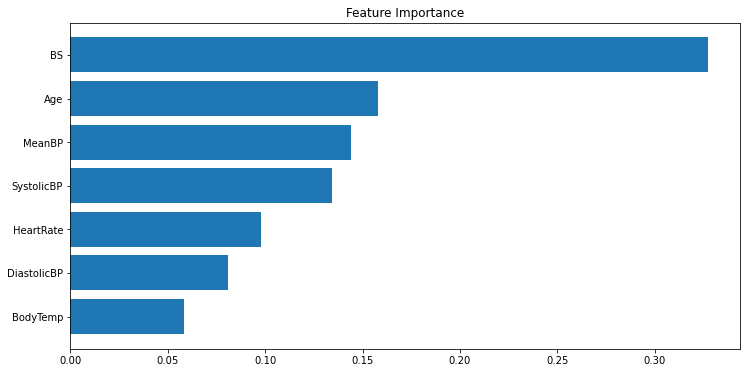

In [22]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
plt.title('Feature Importance');

#### Permutation importance

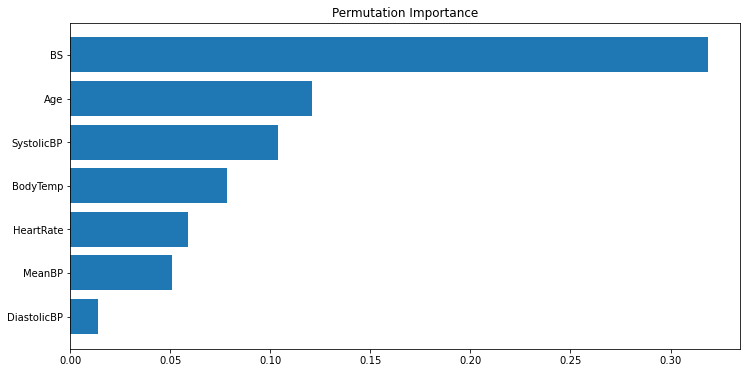

In [23]:
perm_importance = permutation_importance(model, features_train, target_train, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
plt.title('Permutation Importance');

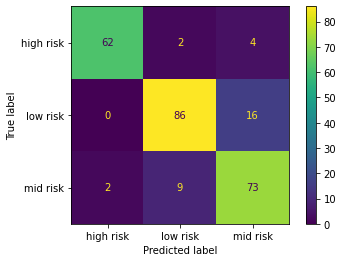

In [112]:
ConfusionMatrixDisplay(confusion_matrix(target_test, model.predict(features_test)), 
                       display_labels=le.inverse_transform([0, 1, 2])).plot();

#### Shape

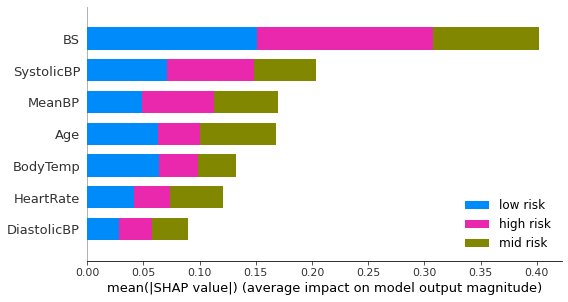

In [56]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features_train)
shap.summary_plot(shap_values, features_train.values, plot_type="bar", 
                  feature_names = features_train.columns, 
                  class_names=le.inverse_transform([0, 1, 2]))

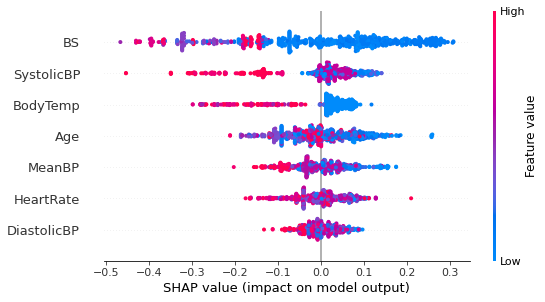

In [57]:
shap.summary_plot(shap_values[1], features_train.values, feature_names = features_train.columns)

In [61]:
i = 6
shap.force_plot(explainer.expected_value[0], shap_values[0][i], 
                features_train.values[i], feature_names = features_train.columns)

Возраст уменьшает риск.

In [74]:
features_train.reset_index(drop=True, inplace=True)

In [79]:
features_train.loc[features_train['Age'].index == 6]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,MeanBP
6,12,90,60,7.5,38.888889,66,70.0


In [81]:
shap_values[0][6]

array([-0.04100509, -0.04423996, -0.02201512, -0.17717984,  0.06111243,
       -0.01587524, -0.02961296])

In [78]:
features_train.loc[features_train['Age'].index == 752]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,MeanBP
752,60,140,90,12.0,36.666667,77,106.666667


In [82]:
shap_values[0][752]

array([-0.01332062,  0.28867681,  0.02383253,  0.20610434, -0.01058412,
       -0.01948923,  0.2359645 ])

In [83]:
features_train.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'MeanBP'],
      dtype='object')

In [155]:
# https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea

Неудачный вариант.

### Логистическая регрессия

In [40]:
numerical = df.select_dtypes(include=['int64', 'float64']).columns.values
num_pipe = Pipeline([('scaler', StandardScaler())])

linear_preprocessor = ColumnTransformer(
    transformers = [('num', num_pipe, numerical)], 
    remainder='passthrough')

In [50]:
model = Pipeline([('preprocessor', linear_preprocessor), 
                  ('model', LogisticRegression(multi_class='multinomial'))])
cross_val_score(model, features_train, target_train)

array([0.625     , 0.61842105, 0.60526316, 0.65131579, 0.59868421])

In [42]:
model = Pipeline([('preprocessor', linear_preprocessor), 
                  ('model', LogisticRegression(multi_class='ovr'))])
cross_val_score(model, features_train, target_train)

array([0.625     , 0.65789474, 0.63157895, 0.66447368, 0.60526316])

In [43]:
model.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'MeanBP'], dtype=object))])),
                ('model', LogisticRegression(multi_class='ovr'))])

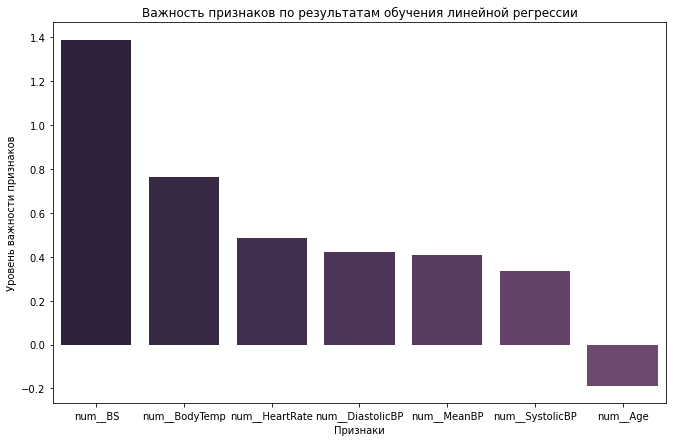

In [44]:
feature_importance = pd.DataFrame(data=model['model'].coef_[0], 
                                  index=model['preprocessor'].get_feature_names_out(),
                                  columns=['importance']) 
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(11,7))
sns.barplot(data=feature_importance,
            x=feature_importance.index,
            y=feature_importance['importance'],
            palette=sns.cubehelix_palette(23, reverse=True))
plt.xlabel('Признаки')
plt.ylabel('Уровень важности признаков')
plt.title('Важность признаков по результатам обучения линейной регрессии')
plt.show()

In [46]:
features_train[4]

KeyError: 4